In [336]:
import os
import tarfile
from six.moves import urllib
from pandas.plotting import scatter_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import hashlib
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion, Pipeline

# Data Cleaning

In [337]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

In [338]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [339]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [340]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [341]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [342]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


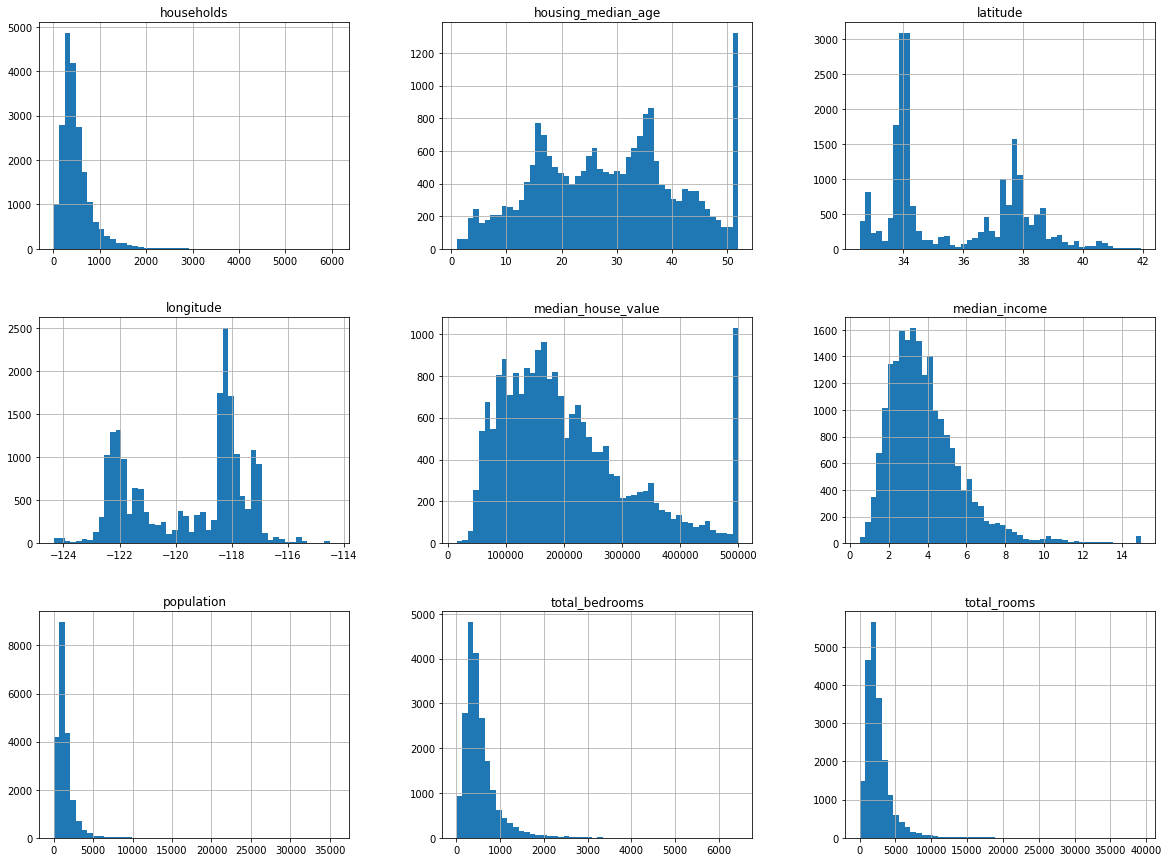

In [343]:
housing.hist(bins=50, figsize=(20,15)) # bins tries to separate the separates if possible, almost sort of like ranges
plt.show()

In [344]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # changes the order of the indices
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [345]:
# OR 

In [346]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [347]:
def split_train_test_id(data, test_ratio, id_col, hash=hashlib.md5):
    ids = data[id_col]
    test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~test_set], data.loc[test_set]

In [348]:
housing_with_id = housing.reset_index()
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [349]:
# train_set, test_set = split_train_test_id(housing_with_id, 0.2, 'index')

In [350]:
# or, you could do 
# train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # random state is the random seed generator number

In [351]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [352]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # n_splits gives n variations of train/test so you can train different models
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [353]:
housing['income_cat'].value_counts() / len(housing) 

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [354]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

housing.drop('income_cat', axis=1, inplace=True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data Visualization

In [355]:
housing_vis = strat_train_set.copy()

In [356]:
housing_vis.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


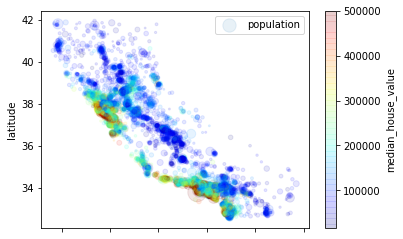

In [357]:
housing_vis.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, s=housing['population']/100, label='population', c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True) # alpha shows the density of data points
plt.legend()

In [358]:
corrs = housing_vis.corr()

In [359]:
corrs['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124270eb8>,
      dtype=object)

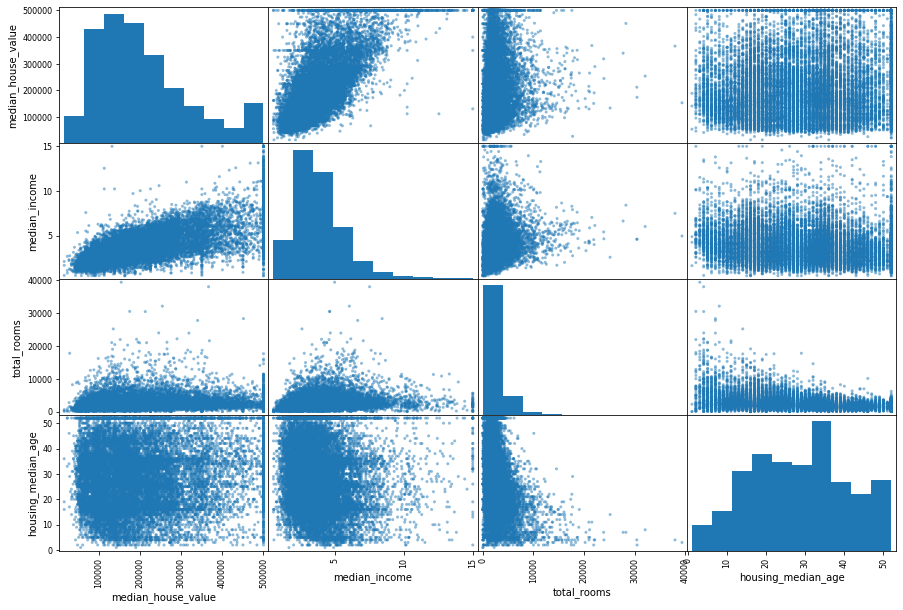

In [360]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing_vis[attributes], figsize=(15, 10))

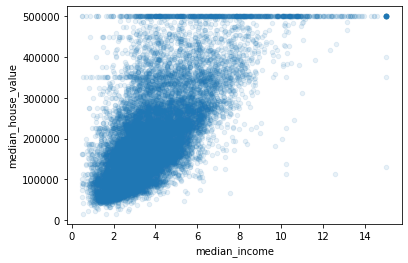

In [361]:
housing_vis.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [362]:
housing_vis['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing_vis['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing_vis['population_per_household'] = housing['population'] / housing['households']

In [363]:
corr = housing_vis.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# More Data Cleaning

In [364]:
housing = strat_train_set.drop('median_house_value', axis=1).copy()
housing_labels = strat_train_set['median_house_value'].copy()

In [365]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [366]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [367]:
# Imputer for filling in missing values

In [368]:
imputer = SimpleImputer(strategy='median')

In [369]:
housing_num = housing.drop('ocean_proximity', axis=1)
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [370]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [371]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [372]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [373]:
# Imputer is an estimator - this takes a dataset as a parameter with a strategy
# Transforms - they use the estimators like the imputers to transform the data with things like the average if need be
# - You can do the first two steps by calling the fit_transform() method, it does both more efficiently
# Predictors are the estimators that are capable of making predictions, like LinearRegression 
# you can use score to measure the quality of the predictions

In [374]:
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']

In [375]:
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [376]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [377]:
# pass in labelecncoded integer categorical variables into onehotencoder

In [378]:
# you can now use onehotencoder() to do both labelencoder and onehotencoder at one time

one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot
# sparse matrix only stores the location of the nonzero elements

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [379]:
# encorder = LabelBinarizer()
# housing_cat_1hot = encoder.fit_transform(housing_cat)
# housing_cat_1hot

In [380]:
# customizable transformer

rooms_ix, bedrooms_ix, population_ix, housing_ix = 3, 4, 5, 6

class AttrAdder(TransformerMixin, BaseEstimator):
    def __init__(self, add_bedrooms=True): # add_bedroom is a hyperparatmer
        self.add_bedrooms = add_bedrooms
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, housing_ix] # need to pass in the index of the column since this is a numpy array
        people_per_household = X[:, population_ix] / X[:, housing_ix] # need to pass in the index of the column since this is a numpy array
        if self.add_bedrooms:
            bedrooms_per_household = X[:, bedrooms_ix] / X[:, housing_ix] # need to pass in the index of the column since this is a numpy array
            return np.c_[X, rooms_per_household, people_per_household, bedrooms_per_household]
        else:
            return np.c_[X, rooms_per_household, people_per_household]

In [381]:
attr_adder = AttrAdder()
attr_adder_data = attr_adder.transform(housing.values)
attr_adder_data

array([[-121.89, 37.29, 38.0, ..., 4.625368731563422, 2.094395280235988,
        1.0353982300884956],
       [-121.93, 37.05, 14.0, ..., 6.008849557522124, 2.7079646017699117,
        0.9557522123893806],
       [-117.2, 32.77, 31.0, ..., 4.225108225108225, 2.0259740259740258,
        1.0194805194805194],
       ...,
       [-116.4, 34.09, 9.0, ..., 6.34640522875817, 2.742483660130719,
        1.1398692810457516],
       [-118.01, 33.82, 31.0, ..., 5.50561797752809, 3.808988764044944,
        1.0674157303370786],
       [-122.45, 37.77, 52.0, ..., 4.843505477308295, 1.9859154929577465,
        1.0672926447574336]], dtype=object)

In [390]:
# Normalizing Data through pipeline
new_housing = housing.copy()
X = new_housing
# print(new_housing.head())
print(type(new_housing))

<class 'pandas.core.frame.DataFrame'>


In [383]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [394]:
class DataFrameSelector(TransformerMixin, BaseEstimator):
    def __init__(self, attribs):
        self.attribs = attribs
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(type(X))
        return X[self.attribs]

In [395]:
num_pipeline = Pipeline([
    ('data_selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_added', AttrAdder()),
    ('standardization', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('data_selector', DataFrameSelector(cat_attribs)),
    ('binarizer', LabelBinarizer()),
])

In [396]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

housing_cleaned = full_pipeline.fit_transform(housing.values)
housing_cleaned

<class 'numpy.ndarray'>


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
housing_cleaned.shape